# Web Scrapping - Preços da Apple
## Projeto Individual - Tiago Vitorino Seixas

Este notebook contém um projeto cujo objetivo é determinar dentre os países das Américas e da Europa quais tem os melhores e piores preços de dispositivos Apple. As fontes consultadas incluem:
- O site da apple hospedado em diferentes países
- A tabela de cotação do banco central do brasil (conversão de valores)

Os dados do site da Apple são alocados dinâmicamente, então além do BeautifulSoup, também foi necessário usar a biblioteca selenium.

Usou-se pandas para manipular os dados.

In [2]:
# para trabalhar com diretórios / sistema operacional
import os

# para nos comunicarmos com a Web
import requests

# para extrair informações de páginas HTML
import bs4
from bs4 import BeautifulSoup

# utilizada para nos indicar o caminho do executável do Python
import sys

# Para criar um Data Frame
import pandas as pd

import re

from datetime import datetime, timedelta

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time

import matplotlib.pyplot as plt

In [15]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.set_page_load_timeout(50)

In [4]:
# Getting all country hrefs (for Europe and the Americas)
url = 'https://www.apple.com/choose-country-region/'

driver.get(url)
driver.implicitly_wait(3000)
time.sleep(2)

country_soup = BeautifulSoup(driver.page_source, 'html.parser')

main = country_soup.find('main')
regioes_linguas = {}
for region in main.find_all('section', class_='category'):
    lista_linguas = []
    region_name = region.get('data-analytics-section-engagement').replace('name:', '')
    if region_name not in regioes_linguas.keys():
        regioes_linguas[region_name] = []
    for button in region.find_all('a', class_='block'):
        href = button.get('href')
        lista_linguas.append(href)
    regioes_linguas[region_name] = list(set(lista_linguas))

lista_linguas = regioes_linguas['north-america'] + regioes_linguas['latin-america'] + regioes_linguas['europe']

# Join hrefs with apple url (except for China, which has the full URL in the href)
apple_url = 'https://www.apple.com'
lista_url_paises = []
for lingua in lista_linguas:
    if lingua == 'https://www.apple.com.cn/':
        lista_url_paises.append(lingua)
    elif lingua != '/':
        lista_url_paises.append(apple_url+lingua)
    else:
        lista_url_paises.append(apple_url+'/')

In [57]:
# If you already have a csv file, pull it's data to avoid repeat work
try:
    df_read = pd.read_csv('data_source.csv')

    old_dict_prices = {}
    for _, row in df_read.iterrows():
        region = row["region"]
        category = row["category"]
        product = row["product"]
        price = row["price"]
        date = row["date"]
        old_dict_prices.setdefault(region, {}).setdefault(category, {})['date'] = date
        old_dict_prices[region][category][product] = price
    old_dict_prices
except:
    old_dict_prices = {}

In [58]:
def check_if_fetched_today(dict_prices, pais, device, today):
    has_date = False
    has_current_date = False
    try:
        if len(dict_prices[pais][device].keys()) >= 1:
            try:
                has_date = 'date' in dict_prices[pais][device].keys()
                if str(dict_prices[pais][device]['date']) == str(today):
                    has_current_date = True
                else:
                    has_current_date = False
            except:
                pass
    except:
        pass

    return has_date, has_current_date

In [59]:
# Fetching Brazilian Central Bank exchange rates
contador = 1
csv_read = True
column_names = [ "Data", "Cod Moeda", "Tipo", "Moeda", "Taxa Compra", "Taxa Venda", "Paridade Compra", "Paridade Venda"]

while contador < 10 and csv_read:
    most_recent_date = datetime.today()
    desired_date = most_recent_date - timedelta(days=contador)
    string_date = desired_date.strftime('%Y%m%d')
    try:
        exchange_rates_to_brl = pd.read_csv(f"https://www4.bcb.gov.br/Download/fechamento/{string_date}.csv", sep=';', header=None, names=column_names)
        csv_read = False
    except:
        contador += 1

In [60]:
iphone_url = 'iphone'
ipad_url = 'ipad'
mac_url = 'mac'
watch_url = 'watch'

lista_url_paises_tmp = ['https://www.apple.com/br/']

dict_prices = {}

for url_pais in lista_url_paises:
    pais = url_pais.replace('https://www.apple.com', '').replace('.', '').replace('/', '')
    if pais == '':
        pais = 'us' 

    dict_prices[pais] = {
        'iphone' : {},
        'ipad' : {},
        'mac' : {},
        'watch' : {},
        'passed' : 'true'
    }

    today = string_date

    # Check if iPhone data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'iphone', today)

    # List with hrefs of countries with problems in the website (Russia and Belarus)
    # Or that do not have any value exposed in the url and also do not have the apple watch tab (as of May 2025)
    list_excluded_countries = [
        'ru',
        'by',
        'li',
        'mk',
        'mt',
        'me',
    ]

    # List with hrefs of countries that do not have the apple watch tab available
    list_no_watch = [
        
    ]

    # If there isn't iPhone data, or if data is not from today, get iPhone data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+iphone_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)
            section_5_countries = [
                'fr',
                'es',
                'uk',
                'de',
                'it',
            ]
            section_3_countries = [
                'lu',
                'nl',
                'se',
                'at',
                'fi',
                'ie',
                'benl',
                'no',
                'befr',
                'pt',
                'dk'
            ]
            if pais in section_5_countries:
                iphone_path = '/html/body/main/section[5]/div[2]/div[2]/div/div[1]/div/ul'
            elif pais in section_3_countries:
                iphone_path = '/html/body/main/section[3]/div[2]/div[2]/div/div[1]/div/ul'
            else:
                iphone_path = '/html/body/main/section[4]/div[2]/div[2]/div[1]/div[1]/div/ul'
            iphone_ul_element = driver.find_element(By.XPATH, iphone_path)
            driver.execute_script("arguments[0].scrollIntoView();", iphone_ul_element)
            time.sleep(1)
            iphone_ul = BeautifulSoup(iphone_ul_element.get_attribute("outerHTML"), 'html.parser')
            iphone_li_list = iphone_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in iphone_li_list:
                title = li.find('p', class_ = 'product-tile-headline')
                price = li.find('span', class_ = 'sosumi-link-follows')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['iphone'][title] = price
                    dict_prices[pais]['iphone']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['iphone']['date'] = today
    else:
        dict_prices[pais]['iphone'] = old_dict_prices[pais]['iphone']
    
    # Check if iPad data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'ipad', today)

    # Get iPad data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+ipad_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)
            ipad_path = '/html/body/div/div/main/section[3]/div/div[2]/div/div[1]/ul'
            ipad_ul_element = driver.find_element(By.XPATH, ipad_path)
            driver.execute_script("arguments[0].scrollIntoView();", ipad_ul_element)
            time.sleep(1)
            ipad_ul = BeautifulSoup(ipad_ul_element.get_attribute("outerHTML"), 'html.parser')
            ipad_li_list = ipad_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in ipad_li_list:
                title = li.find('h3', class_ = 'typography_headline__zZkHA')
                price = li.find('p', class_ = 'ProductTile_pricing__mJzcd typography_bodyCopySemibold__RqR50')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['ipad'][title] = price
                    dict_prices[pais]['ipad']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['ipad']['date'] = today
    else:
        dict_prices[pais]['ipad'] = old_dict_prices[pais]['ipad']

    # Check if MacBook Air/Pro data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'mac', today)
    
    # Get MacBook Air/Pro data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+mac_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)

            mac_path = '/html/body/main/section[3]/div[2]/div[2]/div[1]/div[1]/div/ul'
            mac_path_list = list(mac_path)

            button_path = '/html/body/main/section[3]/div[2]/div[1]/ul/li[2]/button'
            button_path_list = list(button_path)

            if pais == 'us':
                mac_path_list[24] = '4'
                mac_path = ''.join(mac_path_list)
                button_path_list[24] = '4'
                button_path = ''.join(button_path_list)


            notebooks_ul_element = driver.find_element(By.XPATH, mac_path)
            driver.execute_script("arguments[0].scrollIntoView();", notebooks_ul_element)
            time.sleep(1)
            notebooks_ul = BeautifulSoup(notebooks_ul_element.get_attribute("outerHTML"), 'html.parser')

            desktops_button = driver.find_element(By.XPATH, button_path)
            driver.execute_script("arguments[0].scrollIntoView();", desktops_button)
            desktops_button.click()
            time.sleep(1)

            mac_path_list[-16] = '2'
            new_mac_path = ''.join(mac_path_list)
            desktops_ul_element = driver.find_element(By.XPATH, new_mac_path)
            desktops_ul = BeautifulSoup(desktops_ul_element.get_attribute("outerHTML"), 'html.parser')

            button_path_list[-9] = '3'
            new_button_path = ''.join(button_path_list)
            monitors_button = driver.find_element(By.XPATH, new_button_path)
            driver.execute_script("arguments[0].scrollIntoView();", monitors_button)
            monitors_button.click()
            time.sleep(1)

            mac_path_list[-16] = '3'
            new_mac_path = ''.join(mac_path_list)
            monitors_ul_element = driver.find_element(By.XPATH, new_mac_path)
            monitors_ul = BeautifulSoup(monitors_ul_element.get_attribute("outerHTML"), 'html.parser')

            mac_li_list = notebooks_ul.find_all('li') + desktops_ul.find_all('li') + monitors_ul.find_all('li') 
            list_reject = ['', ' ', None]
            for li in mac_li_list:
                title = li.find('p', class_ = 'product-tile-headline')
                price = li.find('p', class_ = 'product-tile-price product-tile-padding has-dynamic-content')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['mac'][title] = price
                    dict_prices[pais]['mac']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['mac']['date'] = today
    else:
        dict_prices[pais]['mac'] = old_dict_prices[pais]['mac']

    # Check if Apple Watch data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'watch', today)

    # Get Apple Watch data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+watch_url)
            driver.implicitly_wait(3000)
            # time.sleep(1)
            if pais == 'ca' or pais == 'cafr':
                watch_ul_element = driver.find_element(By.XPATH, '/html/body/main/section[5]/div[2]/div[1]/div/ul')
                time.sleep(0.5)
            else:
                watch_ul_element = driver.find_element(By.XPATH, '/html/body/main/section[4]/div[2]/div[1]/div/ul')
            driver.execute_script("arguments[0].scrollIntoView();", watch_ul_element)
            time.sleep(1)
            watch_ul = BeautifulSoup(watch_ul_element.get_attribute("outerHTML"), 'html.parser')
            watch_li_list = watch_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in watch_li_list:
                title = li.find('span', class_ = 'product-tile-headline typography-product-tile-headline')
                price = li.find('p', class_ = 'product-tile-price typography-product-tile-subheading product-tile-padding has-dynamic-content')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['watch'][title] = price
                    dict_prices[pais]['watch']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['watch']['date'] = today
    else:
        dict_prices[pais]['watch'] = old_dict_prices[pais]['watch']

    try:
        if dict_prices[pais]['passed'] == 'true':
            pass
        else:
            print(f"Deu ruim {pais}")
    except:
        print(f"Deu ruim {pais}")


In [61]:
print(dict_prices['ca'])

{'iphone': {'date': 20250522, 'iPhone 16 Pro': 1449.0, 'iPhone 16': 1129.0, 'iPhone 16e': 899.0, 'iPhone 15': 999.0}, 'ipad': {'date': 20250522, 'iPad Pro': 1399.0, 'iPad Air': 799.0, 'iPad': 499.0, 'iPad mini': 679.0}, 'mac': {'date': 20250522, 'MacBook Air de 13 e 15 pol.': 1399.0, 'MacBook Pro de 14 e 16 pol.': 2099.0, 'iMac': 1699.0, 'Mac mini': 799.0, 'Mac Studio': 2699.0, 'Mac Pro': 8999.0, 'Studio Display': 1999.0, 'Pro Display XDR': 6299.0}, 'watch': {'date': 20250522, 'Apple Watch SE': 329.0, 'Apple Watch Series 10': 549.0, 'Apple Watch Ultra 2': 1099.0}, 'passed': 'true'}


In [62]:
# Convert dictionary into dataframe
flattened_data = []
for region, products in dict_prices.items():
    if "passed" in products:
        del products["passed"] 
    for category, items in products.items():
        for product, price in items.items():
            if region == '':
                considered_region = 'us'
            else:
                considered_region = region
            if product != 'date':
                flattened_data.append({
                    "region": considered_region.replace('"', '')  ,
                    "category": category.replace('"', '')  ,
                    "product": product.replace('"', '')  ,
                    "price": str(price).replace('"', '') ,
                    "date" : today
                })


df = pd.DataFrame(flattened_data)

df = df.dropna()
df = df[df["price"].str.strip() != ""]
df.map(lambda x: x.replace('\n', ''))
df["price"] = df["price"].str.replace(r"(?<=\d) (?=\d)", "", regex=True)
df["price"] = df["price"].str.replace(r"[.,](?=\d{3}\b)", "", regex=True)
df["price"] = df["price"].str.replace(r"[$€£]", " ", regex=True)
df["price"] = df["price"].str.replace(r"[A-Za-zÀ-ú]", " ", regex=True)
df["price"] = df["price"].str.replace(r"[^\d\s.,]|(?<!\d)[.,]|[.,](?!\d)", "", regex=True)
df["price"] = df["price"].str.replace(',', '.', regex=True)
def extract_full_price(price_string):
    numbers = [float(n.replace(",", "")) for n in re.findall(r"\d+(?:[\.,]\d+)?", price_string)]
    return max(numbers) if numbers else None

df["price"] = df["price"].apply(extract_full_price)
df.head()

,region,category,product,price,date
0,cafr,iphone,iPhone 16 Pro,1449.0,20250522
1,cafr,iphone,iPhone 16,1129.0,20250522
2,cafr,iphone,iPhone 16e,899.0,20250522
3,cafr,iphone,iPhone 15,999.0,20250522
4,cafr,ipad,iPad Pro,1399.0,20250522


In [63]:
# Get desired columns from exchange rate table, and add row with converion rate for the BRL (1 to 1)
desired_columns = ['Moeda', 'Taxa Venda']
exchange_rates_to_brl = exchange_rates_to_brl[desired_columns]
exchange_rates_to_brl = exchange_rates_to_brl.astype(str)
exchange_rates_to_brl["Taxa Venda"] = exchange_rates_to_brl["Taxa Venda"].str.replace(',', '.', regex=True)
exchange_rates_to_brl.loc[len(exchange_rates_to_brl)] = ["BRL", '1.00000000']
exchange_rates_to_brl["Taxa Venda"] = exchange_rates_to_brl["Taxa Venda"].astype(float)

In [64]:
# Dictionary with the href (country) and their respective coins
convert_dict = {
    'us': 'USD', # Moeda EUA
    'cafr': 'CAD', # Moeda Canada
    'ca': 'CAD', # Moeda Canada
    'mx': 'MXN', # Moeda Mexico
    'cl': 'CLP', # Moeda Chile
    'br': 'BRL', # Moeda Brasil
    'lu': 'EUR', # Moeda Luxemburgo (Euro)
    'uk': 'GBP', # Moeda Reino Unido 
    'de': 'EUR', # Moeda Alemanha (Euro)
    'chfr': 'CHF', # Moeda Suica
    'ie': 'EUR', # Moeda Irlanda (Euro)
    'hu': 'HUF', # Moeda Hungria
    'chde': 'CHF', # Moeda Suica
    'no': 'NOK', # Moeda Noruega
    'fr': 'EUR', # Moeda Franca (Euro)
    'pt': 'EUR', # Moeda Portugal (Euro)
    'cz': 'CZK', # Moeda Tchequia
    'dk': 'DKK', # Moeda Dinamarca
    'benl': 'EUR', # Moeda Belgica (Euro)
    'at': 'EUR', # Moeda Austria (Euro)
    'befr': 'EUR', # Moeda Belgica (Euro)
    'nl': 'EUR', # Moeda Paises Baixos (Euro)
    'pl': 'PLN', # Moeda Polonia
    'it': 'EUR', # Moeda Italia (Euro)
    'es': 'EUR', # Moeda Espanha (Euro)
    'se': 'SEK', # Moeda Suecia
    'tr': 'TRY', # Moeda Turquia
    'fi': 'EUR', # Moeda Finlandia (Euro)
}

In [65]:
convert_country_dict = {
    'us': 'EUA', # Moeda EUA
    'cafr': 'Canada', # Moeda Canada
    'ca': 'Canada', # Moeda Canada
    'mx': 'Mexico', # Moeda Mexico
    'cl': 'Chile', # Moeda Chile
    'br': 'Brasil', # Moeda Brasil
    'lu': 'Luxemburgo', # Moeda Luxemburgo (Euro)
    'uk': 'Reino Unido', # Moeda Reino Unido 
    'de': 'Alemanha', # Moeda Alemanha (Euro)
    'chfr': 'Suica', # Moeda Suica
    'ie': 'Irlanda', # Moeda Irlanda (Euro)
    'hu': 'Hungria', # Moeda Hungria
    'chde': 'Suica', # Moeda Suica
    'no': 'Noruega', # Moeda Noruega
    'fr': 'Franca', # Moeda Franca (Euro)
    'pt': 'Portugal', # Moeda Portugal (Euro)
    'cz': 'Tchequia', # Moeda Tchequia
    'dk': 'Dinamarca', # Moeda Dinamarca
    'benl': 'Belgica', # Moeda Belgica (Euro)
    'at': 'Austria', # Moeda Austria (Euro)
    'befr': 'Belgica', # Moeda Belgica (Euro)
    'nl': 'Paises Baixos', # Moeda Paises Baixos (Euro)
    'pl': 'Polonia', # Moeda Polonia
    'it': 'Italia', # Moeda Italia (Euro)
    'es': 'Espanha', # Moeda Espanha (Euro)
    'se': 'Suecia', # Moeda Suecia
    'tr': 'Turquia', # Moeda Turquia
    'fi': 'Finlandia', # Moeda Finlandia (Euro)
}

In [66]:
# Merge exchange rates with data collected
region_df = df
region_df['money_code'] = region_df['region'].map(convert_dict)

merged_df = region_df.merge(exchange_rates_to_brl.rename(columns={'Moeda': 'money_code', 'Taxa Venda': 'exchange_rate'}), on='money_code', how='left')
merged_df['price'] = merged_df['price'].astype(float)
merged_df['price_brl'] = merged_df['price'] * merged_df['exchange_rate']
merged_df['price_brl'] = (merged_df['price_brl']).round(2)
merged_df = merged_df.drop(columns=['money_code', 'exchange_rate'])

In [67]:
# Update table

import warnings

warnings.filterwarnings("ignore")

try:
    update_df = pd.merge(df_read, merged_df, on=['region', 'category', 'product'], how='outer', suffixes=('_old', '_new'))
    update_df["date"] = update_df["date_new"].fillna(update_df["date_old"])  
    update_df["price_brl"] = update_df["price_brl_new"].fillna(update_df["price_brl_old"])
    update_df = update_df[['region', 'category', 'product', 'price', 'price_brl', 'date']]
except:
    update_df = merged_df
    update_df = update_df[['region', 'category', 'product', 'price', 'price_brl', 'date']]

update_df['country'] = update_df['region'].map(convert_country_dict) 

update_df.loc[update_df['product'].str.contains('13', na=False), 'product'] = 'MacBook Air de 13 e 15 pol.'
update_df.loc[update_df['product'].str.contains('14', na=False), 'product'] = 'MacBook Pro de 14 e 16 pol.'

In [68]:
update_df.to_csv('data_source.csv', index=False)

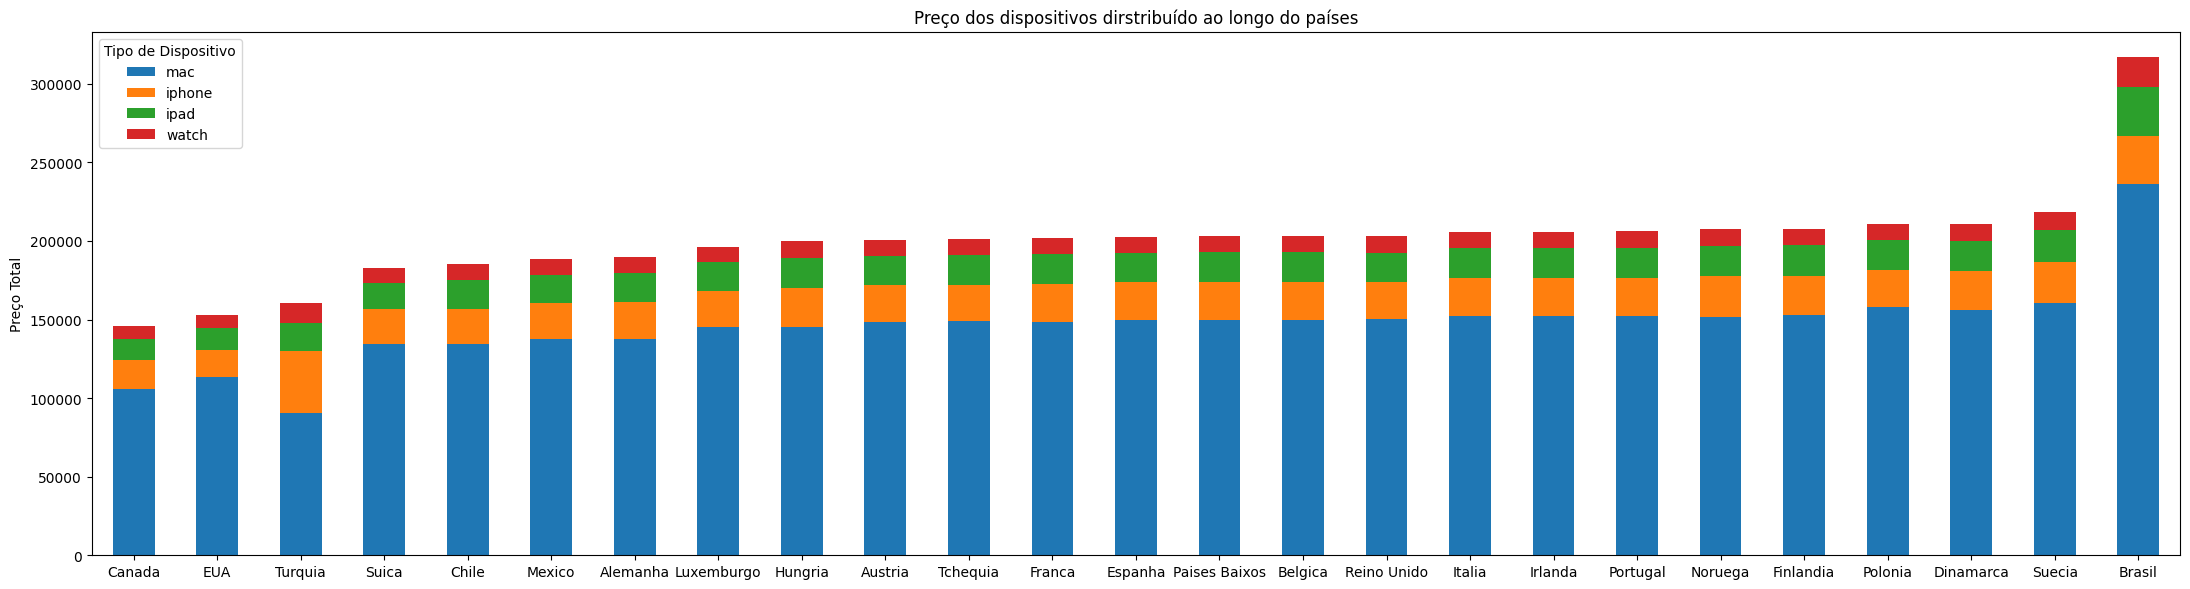

In [69]:
country_df = update_df.drop(columns=['region'])
country_df = country_df.drop_duplicates()

pivot_df = country_df.pivot_table(values='price_brl', index='country', columns='category', aggfunc='sum', fill_value=0)
pivot_table = pivot_df.reindex(['mac','iphone', 'ipad', 'watch'], axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(22, 6))
plt.title('Preço dos dispositivos dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Tipo de Dispositivo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [70]:
pivot_df

category,ipad,iphone,mac,watch
country,,,,
Alemanha,18424.07,23513.58,137372.52,10159.95
Austria,18477.51,23645.92,148575.80,10166.63
Belgica,18805.79,24086.16,149962.73,10159.95
Brasil,31296.00,30596.00,235992.00,19297.00
Canada,13739.31,18215.98,105779.64,8045.80
Chile,18639.92,22200.40,134340.32,10172.62
Dinamarca,19272.14,24730.70,156073.90,10914.57
EUA,13792.99,17458.34,113298.78,8159.63
Espanha,18424.07,23831.68,149961.77,10159.95
